In [1]:
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

# custom functions
from plotting_functions.corr_matrix import plot_corr
from plotting_functions.map_scatter import map_scatter

sns.set()

In [2]:
main_data = pd.read_csv('../data/main_dataset.csv')
main_data

,borough,neighborhood,longitude,latitude,population,restaurant_count,N,bars,bbq,breakfast_brunch,...,store,subway_station,supermarket,synagogue,taxi_stand,tourist_attraction,transit_station,travel_agency,university,veterinary_care
0,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
302,Queens,Hammels,-73.805530,40.587338,12295.0,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
303,Queens,Bayswater,-73.765968,40.611322,25029.0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,0,0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0


In [3]:
old_data = pd.read_csv('../data/old_dataset.csv', index_col=0)
id_data = old_data
old_data

,id,borough,neighborhood,longitude,latitude,population,number_of_restaurants,average_review_count,average_restaurant_rating,average_price_level,yelp_category
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,169,4.0,1,caribbean
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,771,4.0,2,delis
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,532,4.1,1,caribbean
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,297,4.4,1,N
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,319,4.0,2,burgers
...,...,...,...,...,...,...,...,...,...,...,...
301,nyu_2451_34572.302,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,848,4.3,2,newamerican
302,nyu_2451_34572.303,Queens,Hammels,-73.805530,40.587338,12295.0,17,257,4.3,2,chicken_wings
303,nyu_2451_34572.304,Queens,Bayswater,-73.765968,40.611322,25029.0,0,0,0.0,0,N
304,nyu_2451_34572.305,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,222,4.1,2,tradamerican


In [4]:
# let's only take features that are interesting
old_data = old_data[['average_restaurant_rating', 'average_price_level']]
old_data

,average_restaurant_rating,average_price_level
0,4.0,1
1,4.0,2
2,4.1,1
3,4.4,1
4,4.0,2
...,...,...
301,4.3,2
302,4.3,2
303,0.0,0
304,4.1,2


In [5]:
# let's get our encoded yelp_types
yelp_types = pd.read_csv('../data/data/yelp_restaurant_type_counts.csv').drop('Unnamed: 0', axis=1)
yelp_types

,caribbean,breakfast_brunch,pizza,burgers,sandwiches,comfortfood,soulfood,grocery,cafes,chinese,...,airportlounges,surfshop,media,shavedice,pretzels,srilankan,southafrican,personalchefs,homedecor,syrian
0,4.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,1.0,4.0,3.0,2.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,3.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
all_features = pd.read_csv('../data/data/all_features_counts_v3.csv', index_col=0).drop(['population','index'], axis=1)
all_features

,lodging,restaurant,school,health,bar,church,bank,store,clothing,tourist attraction,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,9,55,26,13,10,60,12,36,19,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,39,26,7,4,25,15,37,34,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,33,16,3,11,23,4,36,13,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,54,27,7,14,5,24,19,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,20,25,9,16,12,23,19,5,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,39,60,60,20,60,37,60,60,60,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,3,44,6,9,8,20,3,33,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,4,32,15,6,2,18,7,34,12,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,19,59,36,10,19,25,12,36,7,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# New Features

In [38]:
geo_info = main_data.loc[:,:'population']
geo_info

,borough,neighborhood,longitude,latitude,population
0,Bronx,Wakefield,-73.847201,40.894705,21242.0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0
...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0
302,Queens,Hammels,-73.805530,40.587338,12295.0
303,Queens,Bayswater,-73.765968,40.611322,25029.0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0


In [9]:
main_features = main_data.loc[:,'restaurant_count':]

In [115]:
# scaling
scaler = StandardScaler()
main_features_scaled = pd.DataFrame(scaler.fit_transform(all_features), columns=all_features.columns)
main_features_scaled

,lodging,restaurant,school,health,bar,church,bank,store,clothing,tourist attraction,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,0.209833,0.497484,-0.281050,0.168836,-0.397033,1.401403,-0.520885,-0.346817,-0.259182,-0.607961,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
1,-0.178723,-0.367460,-0.281050,-0.403089,-0.710156,-0.236601,-0.347004,-0.293218,0.477897,-0.607961,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
2,-0.373000,-0.691814,-0.766385,-0.784372,-0.344845,-0.330201,-0.984567,-0.346817,-0.554014,-0.394861,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
3,-0.470139,0.443425,-0.232517,-0.403089,-0.188284,-1.172603,0.174638,-1.258001,-0.996261,0.244438,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
4,-0.373000,-1.394580,-0.329584,-0.212447,-0.083909,-0.845002,0.116678,-1.258001,-0.947122,-0.181762,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,3.123998,0.767779,1.369089,0.836082,2.212331,0.325001,2.261207,0.939559,1.755501,1.949236,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
302,-0.373000,-0.097165,-1.251721,-0.212447,-0.501407,-0.470601,-1.042527,-0.507614,-0.897984,-0.394861,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
303,-0.275862,-0.745873,-0.814919,-0.498409,-0.814531,-0.564201,-0.810686,-0.454015,-0.603152,-0.181762,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
304,1.181221,0.713720,0.204285,-0.117126,0.072653,-0.236601,-0.520885,-0.346817,-0.848845,0.244438,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726


In [13]:
# # scaling
# scaler = StandardScaler()
# features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
# features_scaled

# # # try MinMaxScaler
# # scaler = MinMaxScaler()
# # features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
# # features_scaled

,bars,bbq,breakfast_brunch,burgers,cafes,cantonese,caribbean,chicken_wings,chickenshop,chinese,...,airportlounges,surfshop,media,shavedice,pretzels,srilankan,southafrican,personalchefs,homedecor,syrian
0,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,3.683942,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
1,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
2,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,3.683942,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
3,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
4,-0.081111,-0.05726,-0.242536,7.071068,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,12.328828,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
302,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,17.464249,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
303,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
304,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726


In [116]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(main_features_scaled)

distances, indices = nbrs.kneighbors(main_features_scaled)

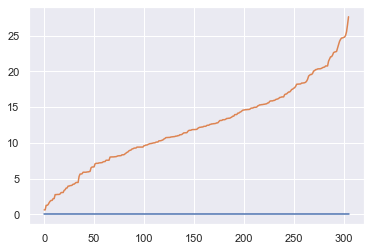

In [117]:
# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [118]:
# between 0.5 and 1.0 seems best
dbscan = DBSCAN(
    eps=5,
    min_samples=5,
    n_jobs=-1
)

In [119]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(main_features_scaled))
clusters.nunique()

2

# This isn't really working, let's try PCA

In [120]:
# remove restaurant count
main_features_scaled

,lodging,restaurant,school,health,bar,church,bank,store,clothing,tourist attraction,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,0.209833,0.497484,-0.281050,0.168836,-0.397033,1.401403,-0.520885,-0.346817,-0.259182,-0.607961,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
1,-0.178723,-0.367460,-0.281050,-0.403089,-0.710156,-0.236601,-0.347004,-0.293218,0.477897,-0.607961,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
2,-0.373000,-0.691814,-0.766385,-0.784372,-0.344845,-0.330201,-0.984567,-0.346817,-0.554014,-0.394861,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
3,-0.470139,0.443425,-0.232517,-0.403089,-0.188284,-1.172603,0.174638,-1.258001,-0.996261,0.244438,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
4,-0.373000,-1.394580,-0.329584,-0.212447,-0.083909,-0.845002,0.116678,-1.258001,-0.947122,-0.181762,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,3.123998,0.767779,1.369089,0.836082,2.212331,0.325001,2.261207,0.939559,1.755501,1.949236,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
302,-0.373000,-0.097165,-1.251721,-0.212447,-0.501407,-0.470601,-1.042527,-0.507614,-0.897984,-0.394861,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
303,-0.275862,-0.745873,-0.814919,-0.498409,-0.814531,-0.564201,-0.810686,-0.454015,-0.603152,-0.181762,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
304,1.181221,0.713720,0.204285,-0.117126,0.072653,-0.236601,-0.520885,-0.346817,-0.848845,0.244438,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726


Text(0, 0.5, 'Variance Explained')

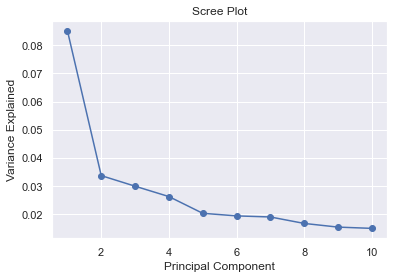

In [121]:
# How many PCs do we want?

pca = PCA(n_components=10)
pca_fit = pca.fit(main_features_scaled)
pca_fit

PC_values = np.arange(pca.n_components_) + 1
PC_values

plt.plot(PC_values, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

In [122]:
# # 3 is the ideal PCA
# pca = PCA(n_components=3)
# features_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2','PC3'])
# features_pca

# Let's try 5
pca = PCA(n_components=5)
features_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2','PC3','PC4','PC5'])
features_pca

,PC1,PC2,PC3,PC4,PC5
0,-3.162422,3.393528,-0.430294,1.576048,-2.645512
1,-3.569769,0.806560,-0.578130,1.519899,-2.095348
2,-3.175148,0.568470,-0.963396,1.315624,-1.642172
3,-2.447268,-1.153465,-0.629575,-1.570602,1.874288
4,-2.184779,-0.498932,0.660584,-1.758793,0.928877
...,...,...,...,...,...
301,8.234117,-0.492504,-1.096676,-1.195812,0.262496
302,-1.430260,-1.842273,-1.697058,-1.346305,0.981127
303,-3.553212,-2.175931,-2.232223,1.409752,0.228118
304,1.920905,0.822100,0.270574,-1.324308,0.250905


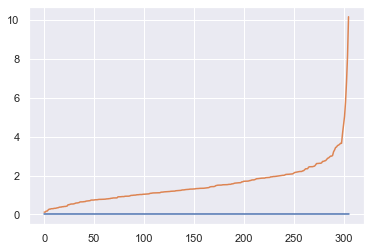

In [123]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_pca)

distances, indices = nbrs.kneighbors(features_pca)

# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [124]:
dbscan = DBSCAN(
    eps=.50,
    min_samples=5,
    n_jobs=-1
)

In [125]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(features_pca))
clusters.nunique()

3

In [126]:
# add back geo info and clusters
clustered_pca = pd.concat([geo_info, features_pca, clusters], axis=1)
clustered_pca = clustered_pca.rename(columns={0:'cluster'})

In [127]:
clustered_pca

,borough,neighborhood,longitude,latitude,population,PC1,PC2,PC3,PC4,PC5,cluster
0,Bronx,Wakefield,-73.847201,40.894705,21242.0,-3.162422,3.393528,-0.430294,1.576048,-2.645512,-1
1,Bronx,Co-op City,-73.829939,40.874294,43752.0,-3.569769,0.806560,-0.578130,1.519899,-2.095348,-1
2,Bronx,Eastchester,-73.827806,40.887556,11506.0,-3.175148,0.568470,-0.963396,1.315624,-1.642172,-1
3,Bronx,Fieldston,-73.905643,40.895437,9287.0,-2.447268,-1.153465,-0.629575,-1.570602,1.874288,-1
4,Bronx,Riverdale,-73.912585,40.890834,9287.0,-2.184779,-0.498932,0.660584,-1.758793,0.928877,-1
...,...,...,...,...,...,...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,8.234117,-0.492504,-1.096676,-1.195812,0.262496,-1
302,Queens,Hammels,-73.805530,40.587338,12295.0,-1.430260,-1.842273,-1.697058,-1.346305,0.981127,-1
303,Queens,Bayswater,-73.765968,40.611322,25029.0,-3.553212,-2.175931,-2.232223,1.409752,0.228118,-1
304,Queens,Queensbridge,-73.945631,40.756091,6677.0,1.920905,0.822100,0.270574,-1.324308,0.250905,-1


In [128]:
def DBSCANplot(data=features_pca, eps=2, min_samples=3, map_plot=True):
    dbscan = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    n_jobs=-1
    )
    
    # fit and predict
    clusters = pd.Series(dbscan.fit_predict(data))
    print(clusters.nunique())

    # add back geo info and clusters
    clustered_pca = pd.concat([geo_info, features_pca, clusters], axis=1)
    clustered_pca = clustered_pca.rename(columns={0:'cluster'})

    if map_plot:
        map_scatter(clustered_pca)


    # reduce to 3D for graphing
    pca = PCA(n_components=2)
    graph_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2'])
    graph_pca = pd.concat([graph_pca,clusters], axis=1)
    graph_pca = graph_pca.rename(columns={0:'cluster'})


    fig = px.scatter(graph_pca, x='PC1', y='PC2',
              color='cluster')
    fig.show()

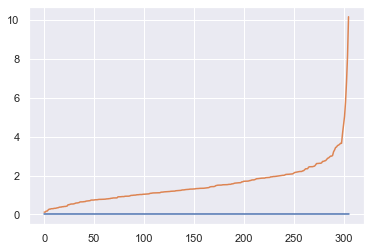

In [129]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_pca)

distances, indices = nbrs.kneighbors(features_pca)

# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [130]:
# Define variable options
eps_options = np.arange(.2,1.5,.1)
min_options = np.arange(3,6,1)

In [131]:
for eps in eps_options:
    for min in min_options:
        print('eps:' + str(eps))
        print('min:' + str(min))
        DBSCANplot(features_pca, eps, min, map_plot=False)

eps:0.2
min:3
1


eps:0.2
min:4
1


eps:0.2
min:5
1


eps:0.30000000000000004
min:3
3


eps:0.30000000000000004
min:4
1


eps:0.30000000000000004
min:5
1


eps:0.4000000000000001
min:3
4


eps:0.4000000000000001
min:4
2


eps:0.4000000000000001
min:5
2


eps:0.5000000000000001
min:3
3


eps:0.5000000000000001
min:4
3


eps:0.5000000000000001
min:5
3


eps:0.6000000000000001
min:3
4


eps:0.6000000000000001
min:4
3


eps:0.6000000000000001
min:5
3


eps:0.7000000000000002
min:3
4


eps:0.7000000000000002
min:4
2


eps:0.7000000000000002
min:5
3


eps:0.8000000000000003
min:3
5


eps:0.8000000000000003
min:4
2


eps:0.8000000000000003
min:5
2


eps:0.9000000000000001
min:3
5


eps:0.9000000000000001
min:4
3


eps:0.9000000000000001
min:5
2


eps:1.0000000000000002
min:3
8


eps:1.0000000000000002
min:4
3


eps:1.0000000000000002
min:5
2


eps:1.1000000000000003
min:3
8


eps:1.1000000000000003
min:4
4


eps:1.1000000000000003
min:5
2


eps:1.2000000000000004
min:3
7


eps:1.2000000000000004
min:4
7


eps:1.2000000000000004
min:5
5


eps:1.3000000000000003
min:3
11


eps:1.3000000000000003
min:4
6


eps:1.3000000000000003
min:5
6


eps:1.4000000000000004
min:3
12


eps:1.4000000000000004
min:4
5


eps:1.4000000000000004
min:5
5


In [112]:
# With PC3, best values are eps:1.6 and min 4
DBSCANplot(features_pca, .5,5)

5


In [31]:
num_top_venues = 5

# We need to remove the venue counts, it's distorting the data

### Google

In [133]:
features_1km.sum().sort_values(ascending=False)[:30].keys()

Index(['doctor', 'lodging', 'restaurant', 'school', 'health', 'bar',
       'secondary_school', 'dentist', 'church', 'bank', 'store',
       'general_contractor', 'clothing_store', 'tourist_attraction', 'gym',
       'real_estate_agency', 'lawyer', 'car_repair', 'bakery', 'hospital',
       'cafe', 'department_store', 'university', 'local_government_office',
       'electronics_store', 'park', 'primary_school', 'drugstore',
       'insurance_agency', 'grocery_or_supermarket'],
      dtype='object')

In [ ]:
['lodging', 'restaurant', 'school', 'health', 'bar', 'church', 'bank', 'store',
       'clothing', 'tourist attraction', 'gym', 'lawyer', 'bakery',
       'cafe', 'department store', 'university', 'local government office',
       'electronics store', 'park', 'drugstore', 'supermarket']